In [2]:
import pandas as pd
import matplotlib.pyplot as plt #Scatterplot

Ingesting the data

In [3]:
#The data is placed in an folder so we load the data through the folder with \
data1 = pd.read_excel("wine-data\winequality-red.xlsx", header=1)
data2 = pd.read_excel("wine-data\winequality-white.xlsx", header=1)

Aggregating the data together into one data file - but first we add a column named type

In [4]:
#Adding the type
data1["type"] = "red"
data2["type"] = "white"

# Merge/concatenate - the ignore_index resets the index numbers
wine = pd.concat([data1, data2], ignore_index=True)

In [5]:
#Shows a random sample, to show that the data is mixed
wine.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
2788,7.6,0.260,0.47,1.60,0.068,5.0,55.0,0.99440,3.10,0.45,9.6,5,white
3566,8.0,0.230,0.35,9.20,0.044,53.0,186.0,0.99700,3.09,0.56,9.5,7,white
5490,7.1,0.200,0.37,1.50,0.049,28.0,129.0,0.99226,3.15,0.52,10.8,5,white
2796,7.3,0.220,0.40,14.75,0.042,44.5,129.5,0.99980,3.36,0.41,9.1,7,white
6269,6.6,0.285,0.49,11.40,0.035,57.0,137.0,0.99732,3.08,0.54,8.9,6,white
2940,7.6,0.540,0.23,2.00,0.029,13.0,151.0,0.99310,3.04,0.33,10.4,5,white
2580,7.7,0.280,0.33,6.70,0.037,32.0,155.0,0.99510,3.39,0.62,10.7,7,white
3332,8.1,0.300,0.31,1.10,0.041,49.0,123.0,0.99140,2.99,0.45,11.1,6,white
564,13.0,0.470,0.49,4.30,0.085,6.0,47.0,1.00210,3.30,0.68,12.7,6,red
402,12.2,0.480,0.54,2.60,0.085,19.0,64.0,1.00000,3.10,0.61,10.5,6,red


Cleaning the data

In [6]:
#We use shape to show the size of the dataset, through the number of observations and how many variables there are
wine.shape

(6497, 13)

In [7]:
#Finding missing values (null) - It shows how many of the different variables has null values
print(wine.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64


Since there are no null values, we do not need to drop them

In [8]:
#Shows how many duplicated values there are. It compares all of the columns.
wine.duplicated().sum()

np.int64(1177)

We therefore have 1177 duplicates

In [9]:
#This shows the first five duplicates.
duplicates = wine[wine.duplicated()]
print(duplicates.head())

    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4             7.4             0.700         0.00            1.90      0.076   
11            7.5             0.500         0.36            6.10      0.071   
27            7.9             0.430         0.21            1.60      0.106   
40            7.3             0.450         0.36            5.90      0.074   
65            7.2             0.725         0.05            4.65      0.086   

    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
4                  11.0                  34.0   0.9978  3.51       0.56   
11                 17.0                 102.0   0.9978  3.35       0.80   
27                 10.0                  37.0   0.9966  3.17       0.91   
40                 12.0                  87.0   0.9978  3.33       0.83   
65                  4.0                  11.0   0.9962  3.41       0.39   

    alcohol  quality type  
4       9.4        5  red  
11     10.5       

In [10]:
#Dropping the 1177 duplicates and resetting the index
wine.drop_duplicates(inplace=True, ignore_index=True)

Checking for damaged values

In [11]:
#Negative values - 
(wine.drop(columns="type") < 0).sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [12]:
#pH value 7 or bigger for wine, as wine is acid and 7 is neutral - 
wine[(wine['pH']>7)].sum()

fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                   0
type                      0
dtype: object

The outliers for the "accepted" wine values

In [13]:
def check_min_max(list, expected_range):
    report = []
    for col, (min_val, max_val) in expected_range.items():
        count = ((list[col] < min_val) | (list[col] > max_val)).sum()
        report.append({"column": col, "outliers": count})

    report_df = pd.DataFrame(report)
    print(report_df)

In [14]:
#Our expected ranges for red wine
expected_ranges_red = {
    "fixed acidity": (4.6, 15.9),
    "volatile acidity": (0.12, 1.58),
    "citric acid": (0.0, 1.0),
    "residual sugar": (0.9, 15.5),
    "chlorides": (0.012, 0.611),
    "free sulfur dioxide": (1, 72),
    "total sulfur dioxide": (6, 289),
    "density": (0.99007, 1.00369),
    "pH": (2.74, 4.01),
    "sulphates": (0.33, 2.0),
    "alcohol": (8.4, 14.9),
    "quality": (3, 8)
}
red_wine = wine[wine["type"] == "red"]

check_min_max(red_wine, expected_ranges_red)

                  column  outliers
0          fixed acidity         0
1       volatile acidity         0
2            citric acid         0
3         residual sugar         0
4              chlorides         0
5    free sulfur dioxide         0
6   total sulfur dioxide         0
7                density         0
8                     pH         0
9              sulphates         0
10               alcohol         0
11               quality         0


In [15]:
#Our expected ranges for white wine
expected_ranges_white = {
    "fixed acidity": (3.8, 14.2),
    "volatile acidity": (0.08, 1.10),
    "citric acid": (0.0, 1.66),
    "residual sugar": (0.6, 65.8),
    "chlorides": (0.009, 0.346),
    "free sulfur dioxide": (2, 289),
    "total sulfur dioxide": (9, 440),
    "density": (0.98711, 1.03898),
    "pH": (2.72, 3.82),
    "sulphates": (0.22, 1.08),
    "alcohol": (8.0, 14.2),
    "quality": (3, 9)
}

#Right now we are only checking for the values of white wine, so we need to filter on the type of wine
white_wine = wine[wine["type"] == "white"]

check_min_max(white_wine, expected_ranges_white)

                  column  outliers
0          fixed acidity         0
1       volatile acidity         0
2            citric acid         0
3         residual sugar         0
4              chlorides         0
5    free sulfur dioxide         0
6   total sulfur dioxide         0
7                density         0
8                     pH         0
9              sulphates         0
10               alcohol         0
11               quality         0


In [16]:
#Shows the count, mean std fopr the collective winelist
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,7.215179,0.344130,0.318494,5.048477,0.056690,30.036654,114.109023,0.994535,3.224664,0.533357,10.549241,5.795677
std,1.319671,0.168248,0.147157,4.500180,0.036863,17.805045,56.774223,0.002966,0.160379,0.149743,1.185933,0.879772
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,153.250000,0.996770,3.330000,0.600000,11.400000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [17]:
#Description of red wine - the list is made previously: red_wine = wine[wine["type"] == "red"]
red_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [18]:
#Description of white wine - the list is made previously: white_wine = wine[wine["type"] == "white"]
white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,6.839346,0.280538,0.334332,5.914819,0.045905,34.889169,137.193512,0.993790,3.195458,0.490351,10.589358,5.854835
std,0.866860,0.103437,0.122446,4.861646,0.023103,17.210021,43.129065,0.002905,0.151546,0.113523,1.217076,0.890683
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.600000,0.035000,23.000000,106.000000,0.991620,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,133.000000,0.993500,3.180000,0.480000,10.400000,6.000000
75%,7.300000,0.330000,0.390000,8.900000,0.050000,45.000000,166.000000,0.995710,3.290000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [19]:
#The shape of red wine after cleaning
red_wine.shape

(1359, 13)

In [20]:
#The shape of white wine after cleaning
white_wine.shape

(3961, 13)

In [ ]:
#Pre Label encoding - Categorical Encoding
wine.dtypes

wine["type"] = wine["type"].astype("category")

wine.dtypes

cat_data = wine.select_dtypes('category').columns

cat_data

# print these columns only
wine[cat_data].sample(10)

categorical_data = wine[cat_data]
categorical_data

,type
0,red
1,red
2,red
3,red
4,red
...,...
5315,white
5316,white
5317,white
5318,white


In [67]:
# Label Endcoding which is converting the text values into numerical values

cats = categorical_data["type"].unique()
cats

categorical_data = wine[["type"]].copy()
categorical_data["type_encoded"] = categorical_data["type"].cat.codes
categorical_data.sample(10)

wine["type_encoded"] = wine["type"].cat.codes
wine.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,type_encoded
380,8.0,0.670,0.30,2.0,0.060,38.0,62.0,0.99580,3.26,0.56,10.2,6,red,0
4530,6.4,0.350,0.28,1.6,0.037,31.0,113.0,0.98779,3.12,0.40,14.2,7,white,1
4995,5.8,0.310,0.31,7.5,0.052,55.0,230.0,0.99490,3.19,0.46,9.8,5,white,1
366,11.9,0.380,0.51,2.0,0.121,7.0,20.0,0.99960,3.24,0.76,10.4,6,red,0
4156,6.1,0.300,0.30,2.1,0.031,50.0,163.0,0.98950,3.39,0.43,12.7,7,white,1
3700,5.5,0.375,0.38,1.7,0.036,17.0,98.0,0.99142,3.29,0.39,10.5,6,white,1
3252,6.7,0.430,0.23,5.0,0.157,49.0,145.0,0.99471,3.17,0.49,9.4,5,white,1
241,7.5,0.650,0.18,7.0,0.088,27.0,94.0,0.99915,3.38,0.77,9.4,5,red,0
4310,7.2,0.240,0.30,1.2,0.037,11.0,95.0,0.98914,2.96,0.36,12.5,6,white,1
4365,6.4,0.160,0.44,1.2,0.051,39.0,122.0,0.99058,3.11,0.75,11.3,7,white,1


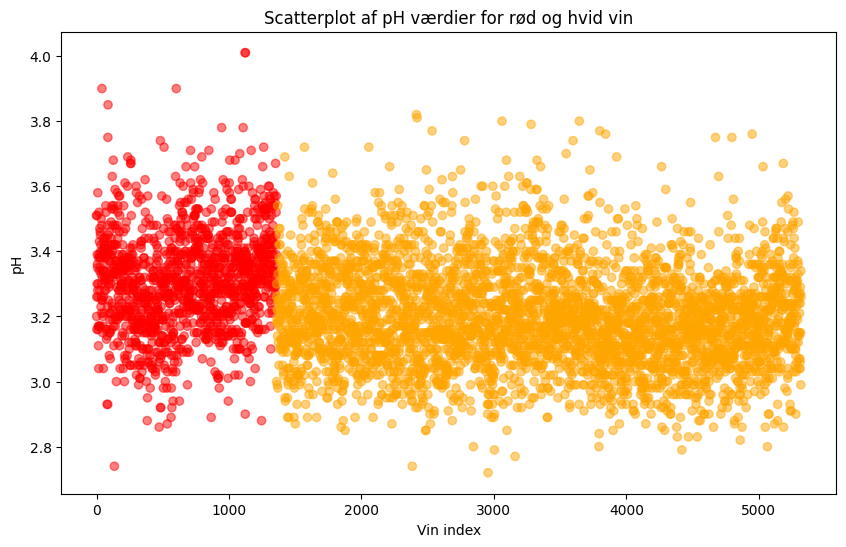

In [22]:
# Scatterplot: x = index (bare rækkefølgen af vin), y = pH
plt.figure(figsize=(10,6))
plt.scatter(wine.index, wine["pH"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
plt.xlabel("Vin index")
plt.ylabel("pH")
plt.title("Scatterplot af pH værdier for rød og hvid vin")
plt.show()


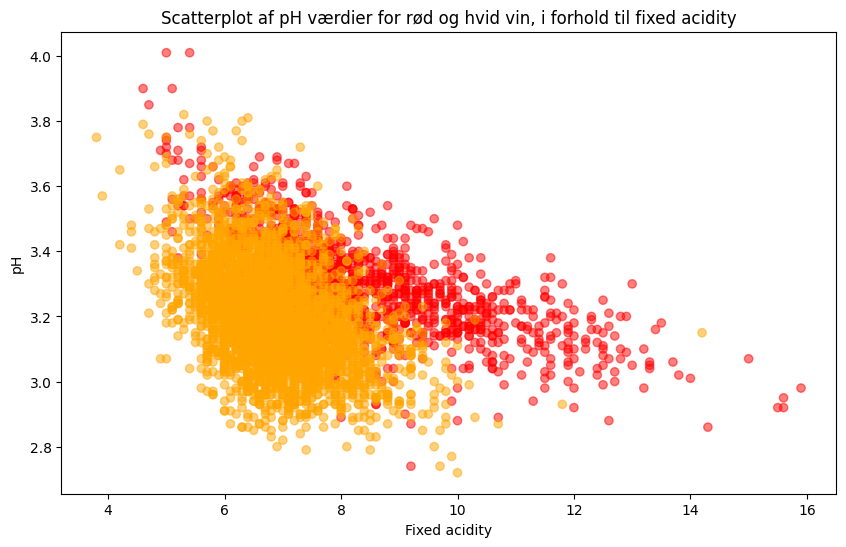

In [23]:
# Scatterplot: x = x = fixed acidity, y = pH
plt.figure(figsize=(10,6))
plt.scatter(wine["fixed acidity"], wine["pH"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
plt.xlabel("Fixed acidity")
plt.ylabel("pH")
plt.title("Scatterplot af pH værdier for rød og hvid vin, i forhold til fixed acidity")
plt.show()

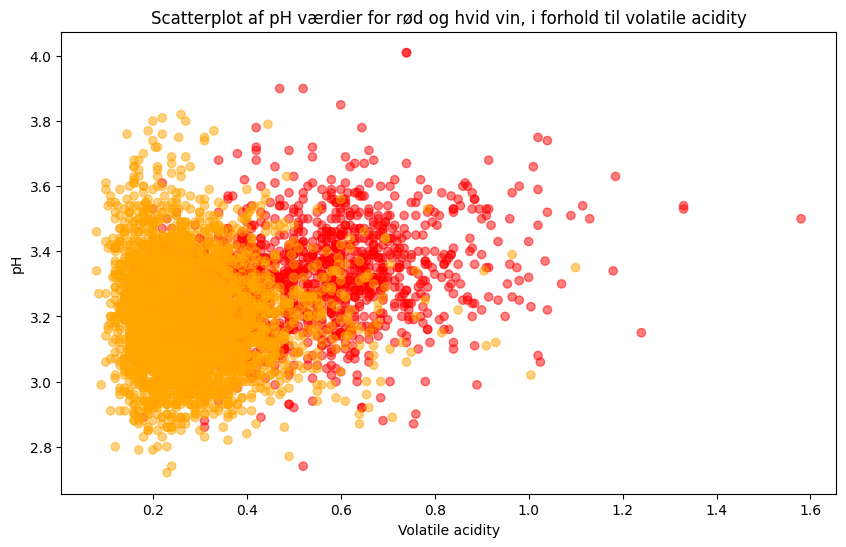

In [24]:
# Scatterplot: x = volatile acidity, y = pH
plt.figure(figsize=(10,6))
plt.scatter(wine["volatile acidity"], wine["pH"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
plt.xlabel("Volatile acidity")
plt.ylabel("pH")
plt.title("Scatterplot af pH værdier for rød og hvid vin, i forhold til volatile acidity")
plt.show()

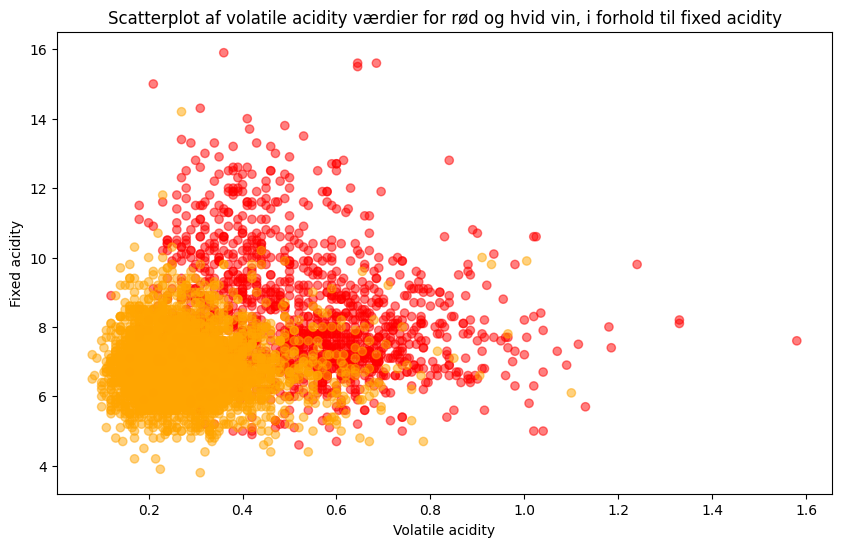

In [25]:
# Scatterplot: x = volatile acidity, y = fixed acidity
plt.figure(figsize=(10,6))
plt.scatter(wine["volatile acidity"], wine["fixed acidity"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
plt.xlabel("Volatile acidity")
plt.ylabel("Fixed acidity")
plt.title("Scatterplot af volatile acidity værdier for rød og hvid vin, i forhold til fixed acidity")
plt.show()

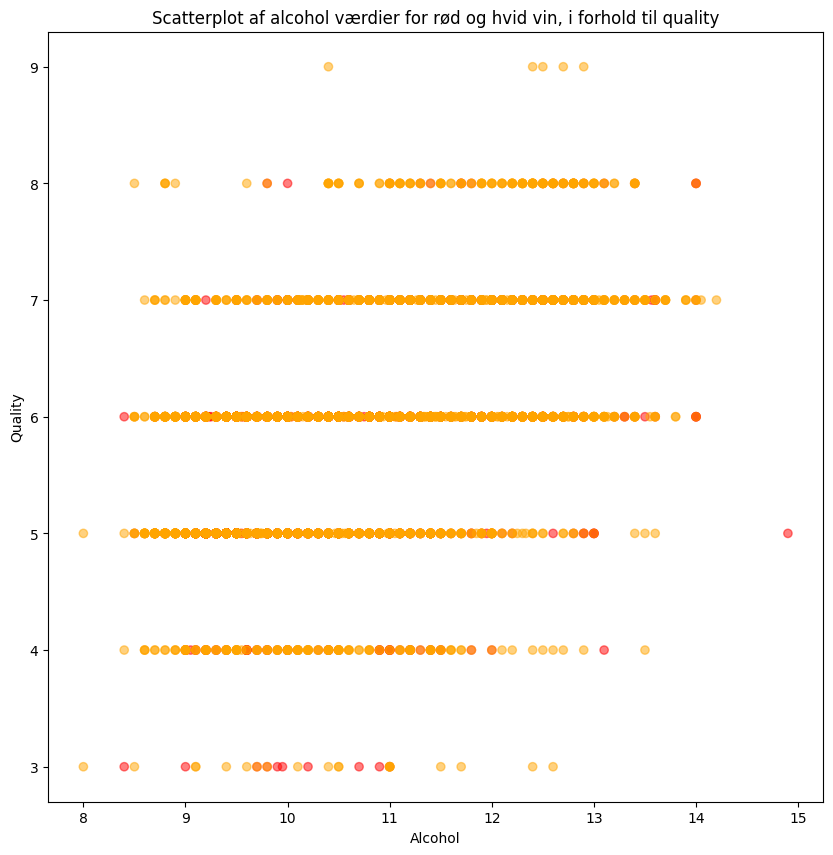

In [26]:
# Scatterplot: x = alcohol, y = quality
plt.figure(figsize=(10,10))
plt.scatter(wine["alcohol"], wine["quality"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
plt.xlabel("Alcohol")
plt.ylabel("Quality")
plt.title("Scatterplot af alcohol værdier for rød og hvid vin, i forhold til quality")
plt.show()

<Figure size 800x600 with 0 Axes>

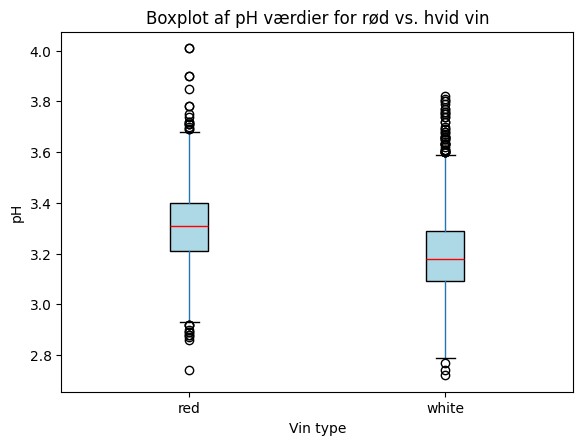

In [27]:
#KOMMER BARE FRA CHAT
plt.figure(figsize=(8,6))
wine.boxplot(column="pH", by="type", grid=False, patch_artist=True,
             boxprops=dict(facecolor="lightblue"),
             medianprops=dict(color="red"))
plt.title("Boxplot af pH værdier for rød vs. hvid vin")
plt.suptitle("")  # fjerner standardtitel
plt.xlabel("Vin type")
plt.ylabel("pH")
plt.show()

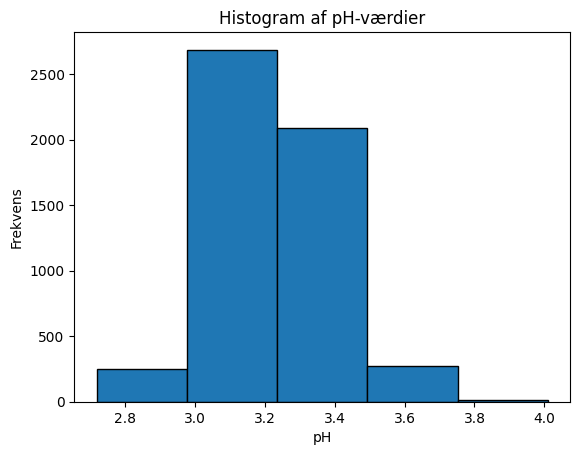

In [28]:
plt.hist(wine["pH"], bins=5, edgecolor="black")
plt.xlabel("pH")
plt.ylabel("Frekvens")
plt.title("Histogram af pH-værdier")
plt.show()

In [29]:
#Checkmark to see if commit and push actually works